In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import time

# Set up variables

In [2]:
# Problem data.
m = 4
n_values = [25, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
b = np.ones(m)

In [3]:
# Number of times to solve the dual equation.
num_dual_samples = 100

# Number of times to solve the stochastic equation.
num_stoc_samples = 10**5

In [4]:
# Set random seed for reproducability.

np.random.seed(23)

In [5]:
def generate_pi():
    rv = np.random.uniform(0, 1)
    return 2**(int(-1*np.log2(rv)) + 1)

In [6]:
def generate_pi(a):
    rv = np.random.uniform(0, 1)
    return 2**(int(-1*np.log2(rv)) + 1)

# Solve for the stochastic program

In [7]:
# Solve for the stochastic program.

# This is deterministic.

# From TA office hours: We cannot use the expectations
# of A and pi instead of their samples of A and pi,
# because we cannot exchange the function and inequality.
# Therefore, we have to generate very many samples of A 
# and pi, and truly calculate the expectation.
print("Stochastic Program Results")

# Create dictionary to store stochastic program results
n_to_stochastic_p = dict()

start = time.time()

for n in n_values:
    # Solve the stochastic problem.
    d = b / n
    
    # Construct the stochastic problem.
    p = cp.Variable(m)
    
    A = np.random.uniform(-0.5, 1, (m, num_stoc_samples))
    pi = generate_pi(0)
        
    objective = cp.Minimize((d @ p) + (1/num_stoc_samples)*cp.sum(cp.maximum(0,pi - (np.transpose(A) @ p))))

    constraints = [p >= 0]

    prob = cp.Problem(objective, constraints)

    # Solve the stochastic problem.
    result = prob.solve()
    now = time.time()
    print("\nWith n=%d, iteration completed in %.2f s" % (n, now - start))
    print(p.value)
    
    n_to_stochastic_p[n] = p.value
    

Stochastic Program Results

With n=25, iteration completed in 1.98 s
[3.92044282 3.87976222 3.95645312 3.90102621]

With n=50, iteration completed in 4.08 s
[4.78023616 4.81300487 4.81545186 4.87688688]

With n=100, iteration completed in 7.05 s
[45.25896191 45.545461   45.21147475 45.55465293]


/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(



With n=200, iteration completed in 14.16 s
[12.68011159 12.60560169 12.54450959 12.56605285]

With n=300, iteration completed in 16.43 s
[3.23188893 3.27326539 3.32723786 3.24949516]

With n=400, iteration completed in 23.51 s
[3.43891743 3.39807617 3.42573411 3.40821705]

With n=500, iteration completed in 25.80 s
[3.42489553 3.42099407 3.46910671 3.42148175]

With n=600, iteration completed in 28.47 s
[13.71834082 13.89802247 13.87011857 13.65061958]

With n=700, iteration completed in 35.45 s
[55.50714647 55.18271313 55.30135304 55.14030738]

With n=800, iteration completed in 42.57 s
[6.89948448 7.1129264  6.95278131 7.0497323 ]

With n=900, iteration completed in 49.67 s
[3.4823911  3.45891817 3.53857366 3.48979608]

With n=1000, iteration completed in 51.99 s
[3.55249431 3.5337375  3.49985876 3.5575543 ]


# Solve for the dual problem for various values of n

In [8]:
# Create dictionaries to save results of simulations

n_to_diffs = dict()
n_to_mean_diffs = dict()
n_to_log_factors = dict()
n_to_C = dict()

##########################################################
# Solve the dual problem.
    
for n in n_values:
    d = b / n
    
    # Create an array to store all of the simulations.
    p_n_values = np.zeros((num_dual_samples, m))
    
    # Solve for one iteration of the offline dual optimal solution.
    for i in range(num_dual_samples):
        # Generate sample A_j and pi_j's (all at once in array)
        
        A = np.random.uniform(-0.5, 1, (m, n))
        pi = np.fromfunction(generate_pi, (n,))

        
        # Construct the stochastic problem.
        p_n = cp.Variable(m)

        # We could do the sum of up to t terms if this was truly online;
        # however since this is offline we can use matrix operations.

        objective = cp.Minimize((d @ p_n) + (1/n)*cp.sum(cp.maximum(0,pi - (np.transpose(A) @ p_n))))

        constraints = [p_n >= 0]

        prob = cp.Problem(objective, constraints)

        # Solve the offline dual problem.
        result = prob.solve()

        p_n_values[i] = p_n.value
        
        
    
    # Compute the 2-norm difference from the stochastic solution
    diffs = [np.linalg.norm(p_n_values[i]-n_to_stochastic_p[n], ord=2)**2 for i in range(num_dual_samples)]
    
    # Compute the log difference based on m and n
    log_factor = m*np.log(m)*np.log(np.log(n))/n
    
    # Compute the coefficient C from dividing the mean of the differences by the log_factor
    C = np.mean(diffs) / log_factor
    
    # Save all results to the dictionary
    n_to_diffs[n] = diffs
    n_to_mean_diffs[n] = np.mean(diffs)
    n_to_log_factors[n] = log_factor
    n_to_C[n] = C
    
    # Print results
    print("For n = %d" % (n))
    print("Average of all dual solutions: %s" % (np.mean(p_n_values, axis=0)))
    print("Expectation of L2 norm between p*n and p* is: %.2f" % (np.mean(diffs)))
    print("m log m log log n / n for m=%d and n=%d is: %.2f" % (m, n, log_factor))
    print("Constant C is: %.3f\n" % (C))

For n = 25
Average of all dual solutions: [6.37643397 5.62388946 6.55021182 5.9791673 ]
Expectation of L2 norm between p*n and p* is: 713.10
m log m log log n / n for m=4 and n=25 is: 0.26
Constant C is: 2750.099

For n = 50
Average of all dual solutions: [7.8468845  9.24400932 8.32100707 6.86387232]
Expectation of L2 norm between p*n and p* is: 774.32
m log m log log n / n for m=4 and n=50 is: 0.15
Constant C is: 5118.495

For n = 100
Average of all dual solutions: [11.7539096  14.09042161 13.36182319 11.93305134]
Expectation of L2 norm between p*n and p* is: 7008.14
m log m log log n / n for m=4 and n=100 is: 0.08
Constant C is: 82755.546

For n = 200
Average of all dual solutions: [14.86164768 12.71231931 15.03025801 13.72817073]
Expectation of L2 norm between p*n and p* is: 4500.39
m log m log log n / n for m=4 and n=200 is: 0.05
Constant C is: 97348.196

For n = 300
Average of all dual solutions: [17.34541304 19.54976749 17.08494298 15.95974909]
Expectation of L2 norm between p*n 

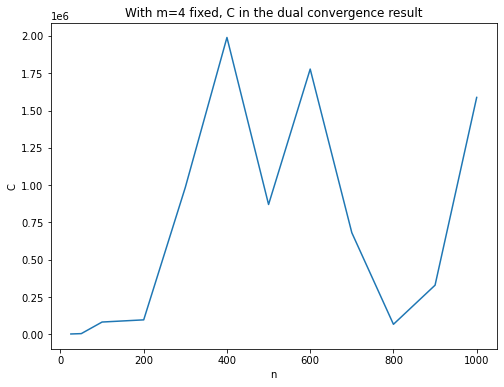

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(list(n_to_C.keys()), list(n_to_C.values()))
plt.xlabel("n")
plt.ylabel("C")
plt.title("With m=%d fixed, C in the dual convergence result" % (m))
plt.show()

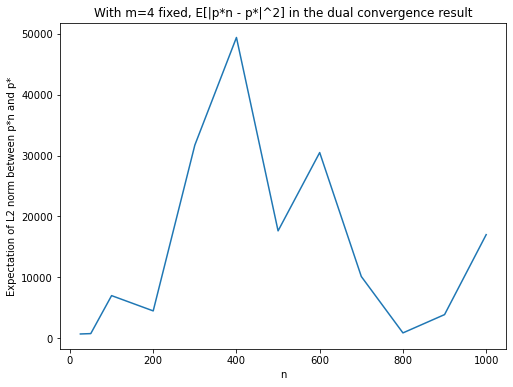

In [10]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(list(n_to_diffs.keys()), list(n_to_mean_diffs.values()))
plt.xlabel("n")
plt.ylabel("Expectation of L2 norm between p*n and p*")
plt.title("With m=%d fixed, E[|p*n - p*|^2] in the dual convergence result" % (m))
plt.show()

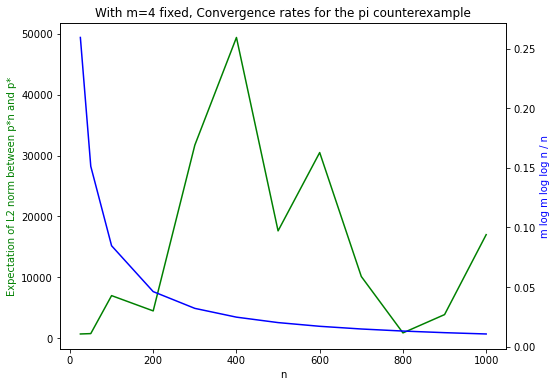

In [12]:
fig, ax1 = plt.subplots(figsize=(8,6))


ax2 = ax1.twinx()

x = list(n_to_diffs.keys())
y1 = list(n_to_mean_diffs.values())
y2 = [m*np.log(m)*np.log(np.log(n))/n for n in x]

ax1.plot(x, y1, 'g-', label="Expectation of L2 norm between p*n and p*")
ax2.plot(x, y2, 'b-', label='m log m log log n / n')
ax1.set_xlabel("n")
ax1.set_ylabel("Expectation of L2 norm between p*n and p*", color='g')
ax2.set_ylabel("m log m log log n / n", color='b')
plt.title("With m=%d fixed, Convergence rates for the pi counterexample" % (m))
#plt.legend()

plt.show()